# simulated luminous galaxies that are red in UV
In the `dustfm` project, EAGLE, TNG, and SIMBA without dust attenuation all have quiescent galaxies with very red UV color: $FUV - NUV > 2.5$. These instrinsically UV red galaxies are important because these galaxies are not observed in SDSS. Therefore, when we infer dust attenuation, EDAs that attenuate these UV red galaxies produce better fits to the observations. For EAGLE and TNG this does not seem like a major issue since there aren't many luminous UV red galaxies. However, SIMBA has a substantial number of luminous UV red galaxies. 

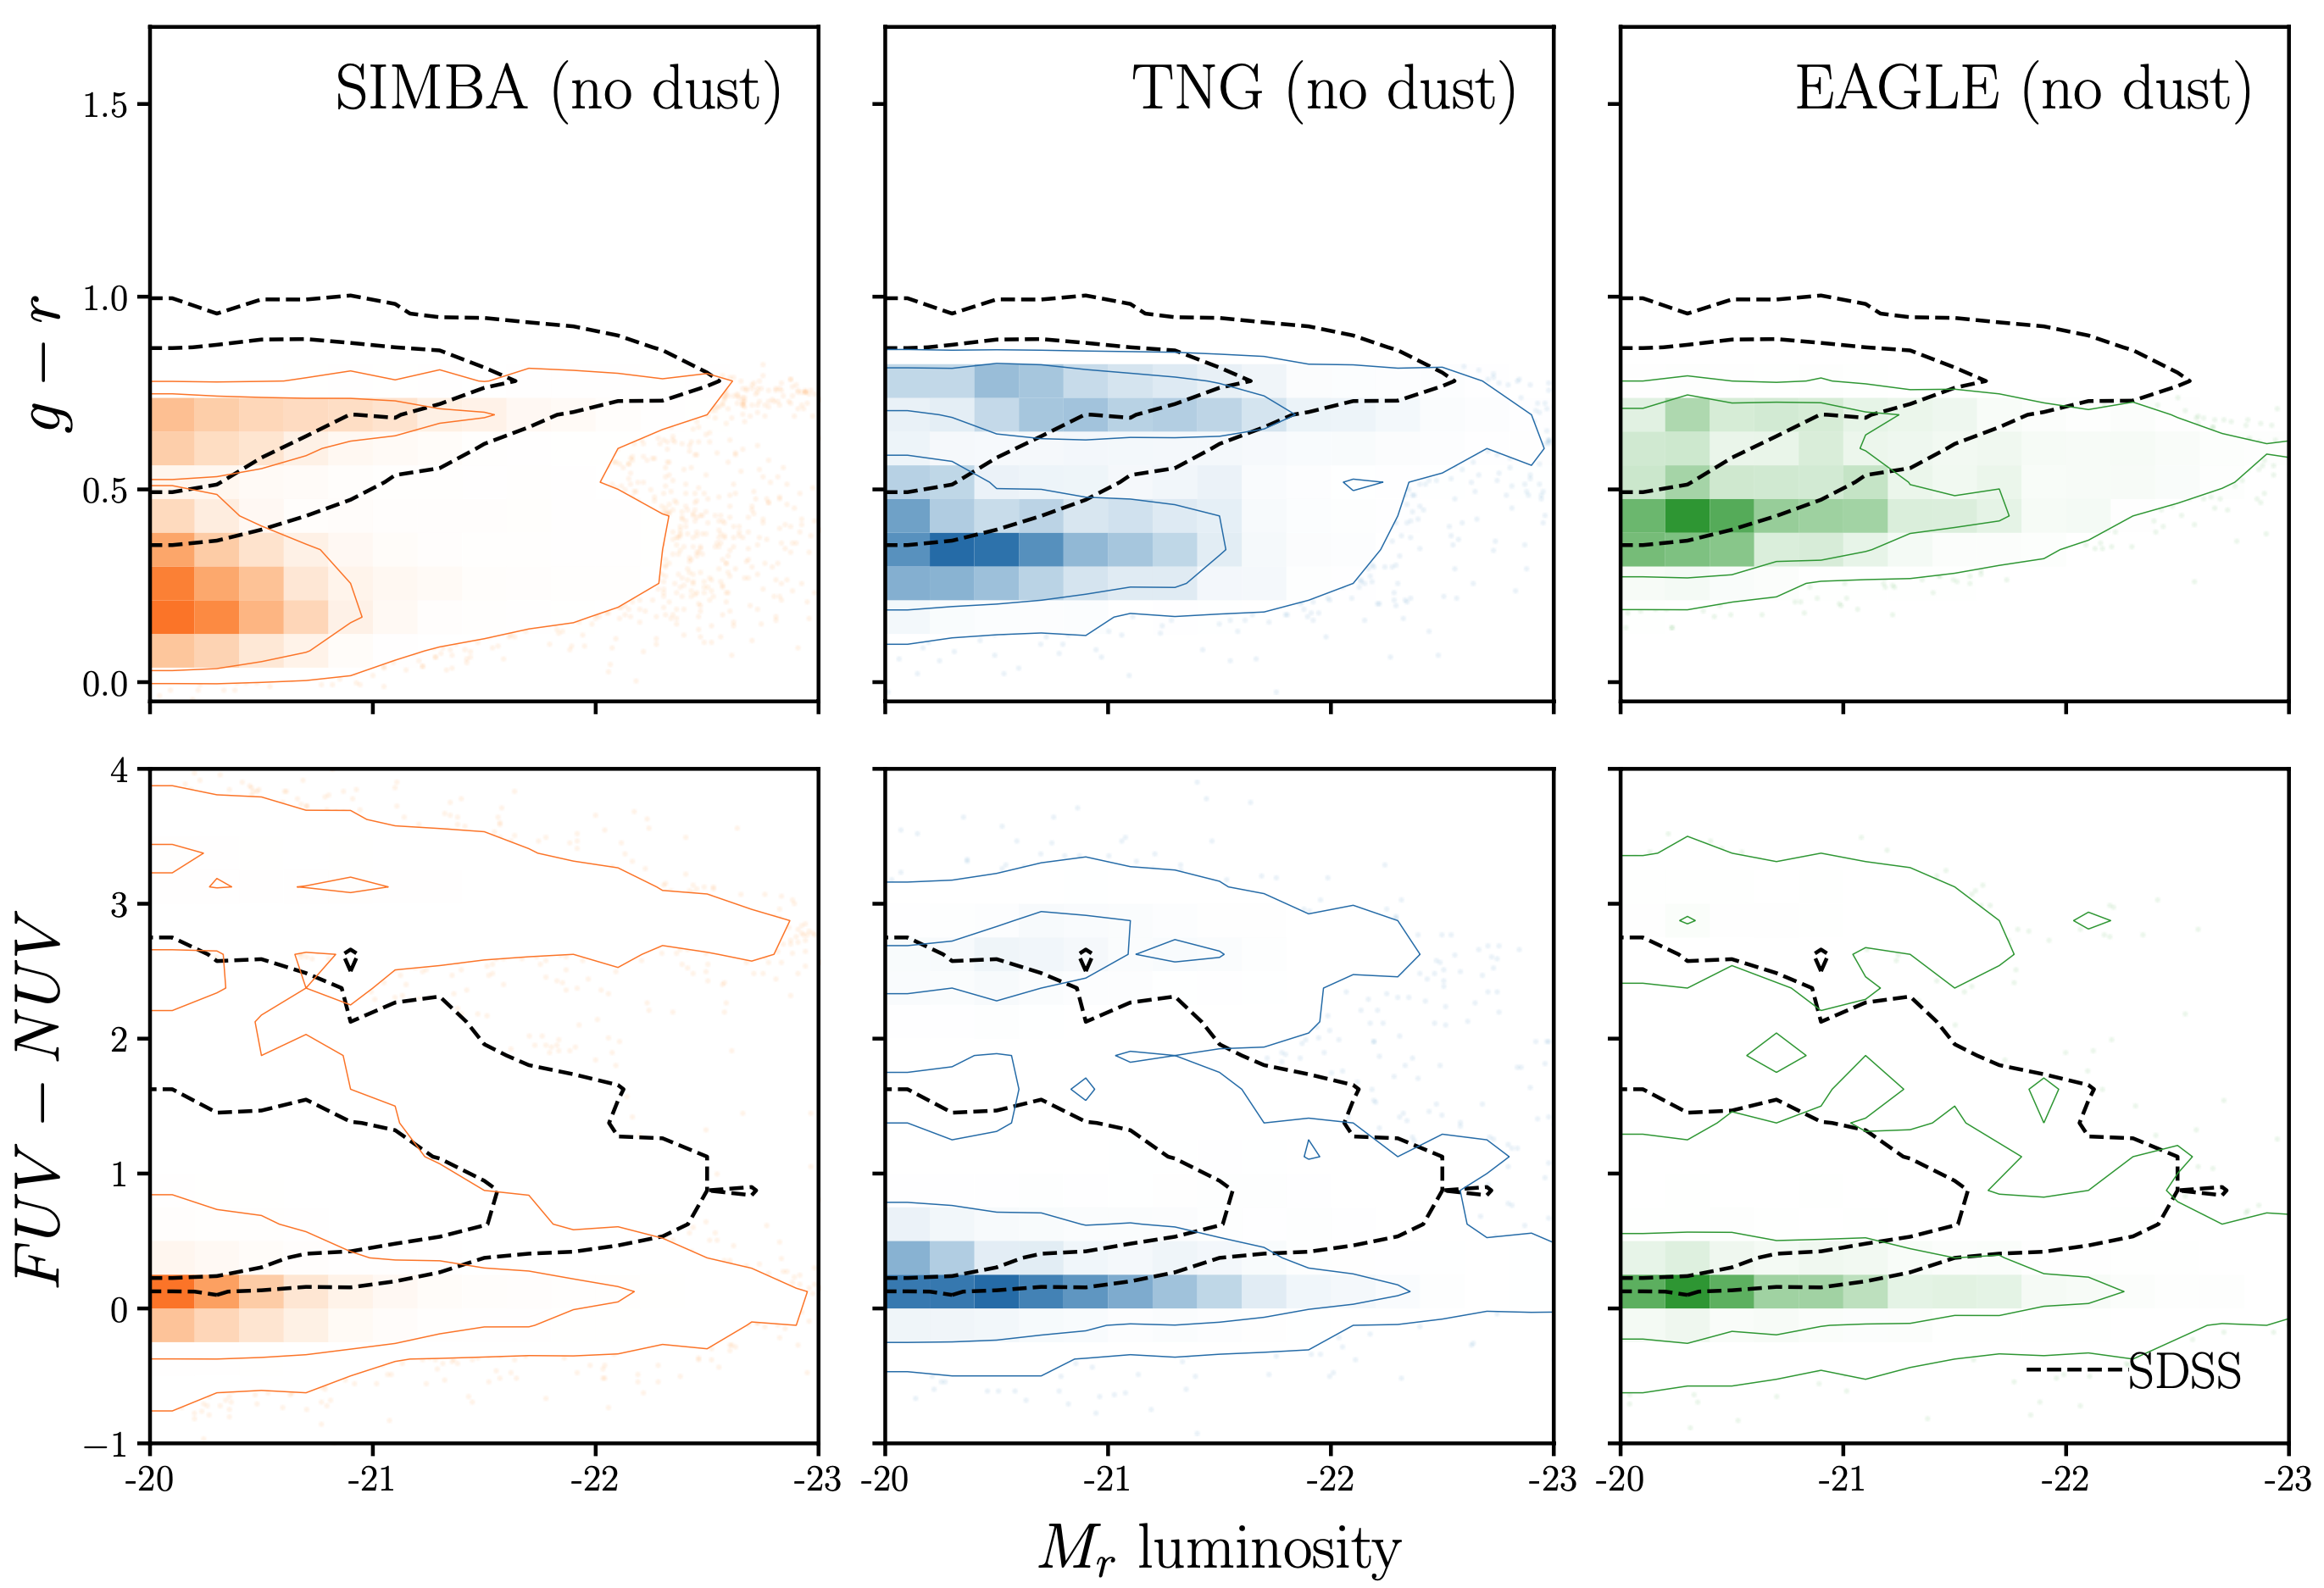

In [1]:
import os 
import sys 
import h5py 
import numpy as np 
import corner as DFM 
# -- galpopfm --
from galpopfm.catalogs import Catalog
from galpopfm import dustfm as dustFM
from galpopfm import dust_infer as dustInfer
from galpopfm import measure_obs as measureObs

In [2]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
def fm(sim, theta): 
    ''' read specified simulations and run through forward model.  
    '''
    _sim_sed = dustInfer._read_sed(sim) 
    wlim = (_sim_sed['wave'] > 1e3) & (_sim_sed['wave'] < 8e3) 

    zerosfr = (_sim_sed['logsfr.inst'] == -999)

    sim_sed = {} 
    sim_sed['sim']          = sim 
    sim_sed['logmstar']     = _sim_sed['logmstar'].copy()
    sim_sed['logsfr.inst']  = _sim_sed['logsfr.inst'].copy() 
    sim_sed['wave']         = _sim_sed['wave'][wlim].copy()
    sim_sed['sed_noneb']    = _sim_sed['sed_noneb'][:,wlim].copy() 
    sim_sed['sed_onlyneb']  = _sim_sed['sed_onlyneb'][:,wlim].copy() 
    
    x_mod, cuts = dustInfer.sumstat_model(
            theta, 
            sed=sim_sed, 
            dem='slab_noll_mssfr_fixbump',
            statistic='2d', 
            sfr0_prescription='sfrmin', 
            noise=False, 
            return_datavector=True) 
    
    sim_sed['logmstar'] = sim_sed['logmstar'][cuts] 
    sim_sed['logsfr.inst'] = sim_sed['logsfr.inst'][cuts]
    sim_sed['sed_noneb'] = sim_sed['sed_noneb'][cuts,:]
    return x_mod, sim_sed, zerosfr[cuts]

# get observables without dust attenuation 

In [4]:
x_simba, simba, sfr0_simba = fm('simba', np.zeros(6))
x_eagle, eagle, sfr0_eagle = fm('eagle', np.zeros(6))
x_tng, tng, sfr0_tng = fm('tng', np.zeros(6))

(-1.0, 4.0)

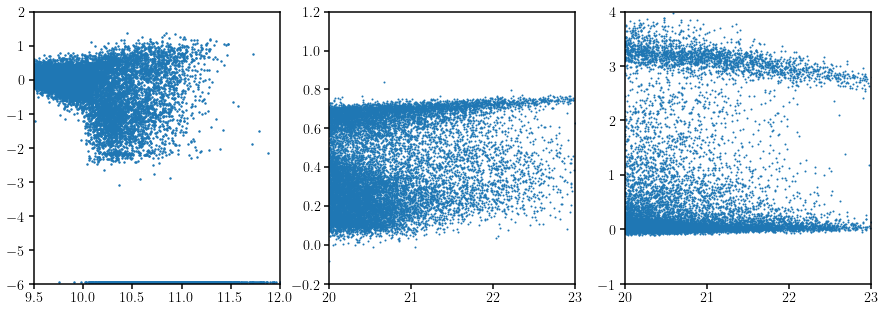

In [5]:
fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(131)
sub.scatter(simba['logmstar'][x_simba[0] > 20], simba['logsfr.inst'][x_simba[0] > 20], s=2)
sub.set_xlim(9.5, 12)
sub.set_ylim(-6, 2)

sub = fig.add_subplot(132)
sub.scatter(x_simba[0], x_simba[1], s=1)
sub.set_xlim(20, 23)
sub.set_ylim(-0.2, 1.2)

sub = fig.add_subplot(133)
sub.scatter(x_simba[0], x_simba[2], s=1)
sub.set_xlim(20, 23)
sub.set_ylim(-1, 4)

## identify quiescent based on SSFR

In [46]:
quiescent = (simba['logsfr.inst'] - simba['logmstar'] < -11)

(-1.0, 4.0)

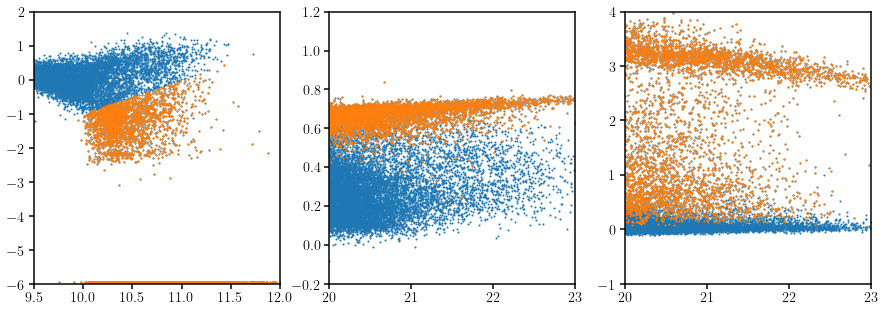

In [47]:
fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(131)
sub.scatter(simba['logmstar'][x_simba[0] > 20], simba['logsfr.inst'][x_simba[0] > 20], s=1)
sub.scatter(simba['logmstar'][(x_simba[0] > 20) & quiescent], 
            simba['logsfr.inst'][(x_simba[0] > 20) & quiescent],s=1)
sub.set_xlim(9.5, 12)
sub.set_ylim(-6, 2)

sub = fig.add_subplot(132)
sub.scatter(x_simba[0], x_simba[1], s=1)
sub.scatter(x_simba[0][quiescent], x_simba[1][quiescent], s=1)
sub.set_xlim(20, 23)
sub.set_ylim(-0.2, 1.2)

sub = fig.add_subplot(133)
sub.scatter(x_simba[0], x_simba[2], s=1)
sub.scatter(x_simba[0][quiescent], x_simba[2][quiescent], s=1)
sub.set_xlim(20, 23)
sub.set_ylim(-1, 4)

All of the galaxies with $FUV - NUV > 2.5$ are quiescent. But what's the difference between quiescent galaxies with $FUV - NUV < 2.5$ and $FUV - NUV > 2.5$. 

In [48]:
uv_red = (x_simba[2] > 2.5)

(-1.0, 4.0)

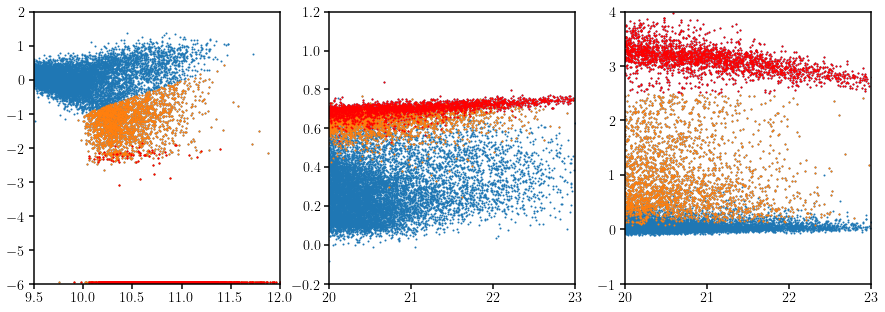

In [49]:
fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(131)
sub.scatter(simba['logmstar'][x_simba[0] > 20], simba['logsfr.inst'][x_simba[0] > 20],s=1)
sub.scatter(simba['logmstar'][(x_simba[0] > 20) & quiescent], 
            simba['logsfr.inst'][(x_simba[0] > 20) & quiescent],s=1)
sub.scatter(simba['logmstar'][(x_simba[0] > 20) & quiescent & uv_red], 
            simba['logsfr.inst'][(x_simba[0] > 20) & quiescent & uv_red], c='r', s=1)
sub.set_xlim(9.5, 12)
sub.set_ylim(-6, 2)

sub = fig.add_subplot(132)
sub.scatter(x_simba[0], x_simba[1], s=1)
sub.scatter(x_simba[0][quiescent & ~uv_red], x_simba[1][quiescent & ~uv_red], c='C1', s=1)
sub.scatter(x_simba[0][quiescent & uv_red], x_simba[1][quiescent & uv_red], c='r', s=1)
sub.set_xlim(20, 23)
sub.set_ylim(-0.2, 1.2)

sub = fig.add_subplot(133)
sub.scatter(x_simba[0], x_simba[2], s=1)
sub.scatter(x_simba[0][quiescent & ~uv_red], x_simba[2][quiescent & ~uv_red], c='C1', s=1)
sub.scatter(x_simba[0][quiescent & uv_red], x_simba[2][quiescent & uv_red], c='r', s=1)
sub.set_xlim(20, 23)
sub.set_ylim(-1, 4)

In [50]:
luminous_uv_red = (x_simba[2] > 2.5) & (x_simba[0] > 22)

(-1.0, 4.0)

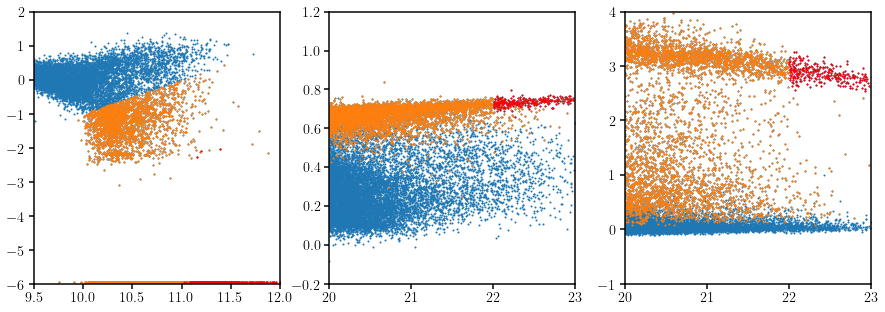

In [52]:
fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(131)
sub.scatter(simba['logmstar'][x_simba[0] > 20], simba['logsfr.inst'][x_simba[0] > 20],s=1)
sub.scatter(simba['logmstar'][(x_simba[0] > 20) & quiescent], 
            simba['logsfr.inst'][(x_simba[0] > 20) & quiescent],s=1)
sub.scatter(simba['logmstar'][(x_simba[0] > 20) & quiescent & luminous_uv_red], 
            simba['logsfr.inst'][(x_simba[0] > 20) & quiescent & luminous_uv_red], c='r', s=1)
sub.set_xlim(9.5, 12)
sub.set_ylim(-6, 2)

sub = fig.add_subplot(132)
sub.scatter(x_simba[0], x_simba[1], s=1)
sub.scatter(x_simba[0][quiescent & ~luminous_uv_red], x_simba[1][quiescent & ~luminous_uv_red], c='C1', s=1)
sub.scatter(x_simba[0][quiescent & luminous_uv_red], x_simba[1][quiescent & luminous_uv_red], c='r', s=1)
sub.set_xlim(20, 23)
sub.set_ylim(-0.2, 1.2)

sub = fig.add_subplot(133)
sub.scatter(x_simba[0], x_simba[2], s=1)
sub.scatter(x_simba[0][quiescent & ~luminous_uv_red], x_simba[2][quiescent & ~luminous_uv_red], c='C1', s=1)
sub.scatter(x_simba[0][quiescent & luminous_uv_red], x_simba[2][quiescent & luminous_uv_red], c='r', s=1)
sub.set_xlim(20, 23)
sub.set_ylim(-1, 4)

Galaxies with $FUV - NUV > 2.5$ have very little SFR. In fact, many of them are SFR = 0 galaxies. Naively this would raise flags regarding the SFR resolution limit. However, the observables are derived from the SED, which is derived from the SFH and ZH

(-1.0, 4.0)

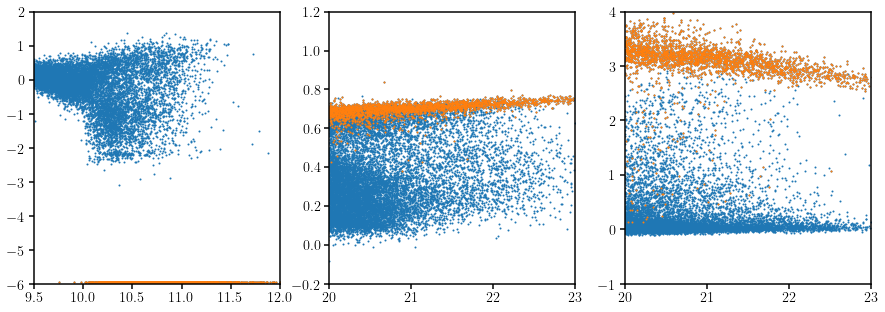

In [10]:
fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(131)
sub.scatter(simba['logmstar'][x_simba[0] > 20], simba['logsfr.inst'][x_simba[0] > 20],s=1)
sub.scatter(simba['logmstar'][(x_simba[0] > 20) & sfr0_simba], simba['logsfr.inst'][(x_simba[0] > 20) & sfr0_simba], s=1)
sub.set_xlim(9.5, 12)
sub.set_ylim(-6, 2)

sub = fig.add_subplot(132)
sub.scatter(x_simba[0], x_simba[1], s=1)
sub.scatter(x_simba[0][sfr0_simba], x_simba[1][sfr0_simba], c='C1', s=1)
sub.set_xlim(20, 23)
sub.set_ylim(-0.2, 1.2)

sub = fig.add_subplot(133)
sub.scatter(x_simba[0], x_simba[2], s=1)
sub.scatter(x_simba[0][sfr0_simba], x_simba[2][sfr0_simba], c='C1', s=1)
sub.set_xlim(20, 23)
sub.set_ylim(-1, 4)

Next, lets look at the SED of the $FUV - NUV > 2.5$ quiescent galaxies and compare them to similar $FUV-NUV < 2.5$ quiescen galaxies

In [11]:
igal_regular_q = np.random.choice(np.arange(len(simba['logmstar']))[quiescent & ~uv_red & (simba['logmstar'] > 10.5) & (simba['logmstar'] < 10.6)], size=1)
igal_uvred_q = np.random.choice(np.arange(len(simba['logmstar']))[quiescent & uv_red & (simba['logmstar'] > 10.5) & (simba['logmstar'] < 10.6)], size=1)

(-1.0, 4.0)

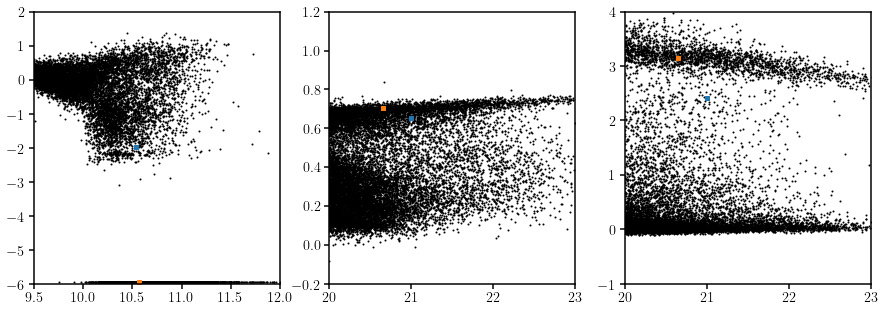

In [12]:
fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(131)
sub.scatter(simba['logmstar'][x_simba[0] > 20], simba['logsfr.inst'][x_simba[0] > 20], c='k', s=1)
sub.scatter(simba['logmstar'][igal_regular_q], simba['logsfr.inst'][igal_regular_q], marker='s', s=20)
sub.scatter(simba['logmstar'][igal_uvred_q], simba['logsfr.inst'][igal_uvred_q], marker='s', s=20)
sub.set_xlim(9.5, 12)
sub.set_ylim(-6, 2)

sub = fig.add_subplot(132)
sub.scatter(x_simba[0], x_simba[1], c='k', s=1)
sub.scatter(x_simba[0][igal_regular_q], x_simba[1][igal_regular_q], marker='s', s=20)
sub.scatter(x_simba[0][igal_uvred_q], x_simba[1][igal_uvred_q], marker='s', s=20)
sub.set_xlim(20, 23)
sub.set_ylim(-0.2, 1.2)

sub = fig.add_subplot(133)
sub.scatter(x_simba[0], x_simba[2], c='k', s=1)
sub.scatter(x_simba[0][igal_regular_q], x_simba[2][igal_regular_q], marker='s', s=20)
sub.scatter(x_simba[0][igal_uvred_q], x_simba[2][igal_uvred_q], marker='s', s=20)
sub.set_xlim(20, 23)
sub.set_ylim(-1, 4)

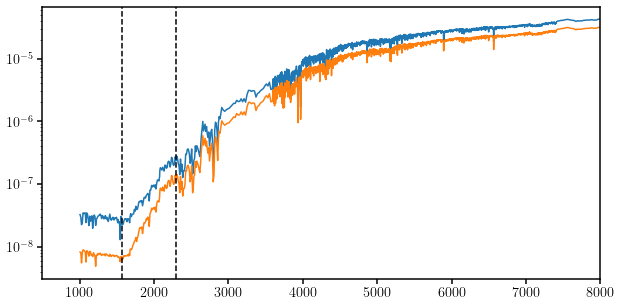

In [13]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(simba['wave'], simba['sed_noneb'][igal_regular_q,:].flatten())
sub.plot(simba['wave'], simba['sed_noneb'][igal_uvred_q,:].flatten())
sub.axvline(1565, color='k', linestyle='--')
sub.axvline(2300, color='k', linestyle='--')
sub.set_xlim(500, 8e3)
sub.set_yscale('log')

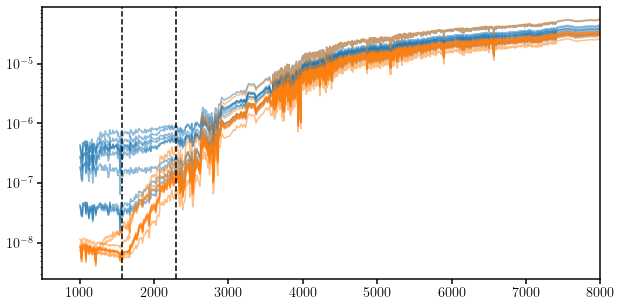

In [14]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for ii in np.random.choice(np.arange(len(simba['logmstar']))[quiescent & ~uv_red & (simba['logmstar'] > 10.5) & (simba['logmstar'] < 10.6)], size=10, replace=False):
    sub.plot(simba['wave'], simba['sed_noneb'][ii,:].flatten(), c='C0', alpha=0.5)
    
for ii in np.random.choice(np.arange(len(simba['logmstar']))[quiescent & uv_red & (simba['logmstar'] > 10.5) & (simba['logmstar'] < 10.6)], size=10, replace=False):
    sub.plot(simba['wave'], simba['sed_noneb'][ii,:].flatten(), c='C1', alpha=0.5)
sub.axvline(1565, color='k', linestyle='--')
sub.axvline(2300, color='k', linestyle='--')
sub.set_xlim(500, 8e3)
sub.set_yscale('log')

# eagle

(-1.0, 4.0)

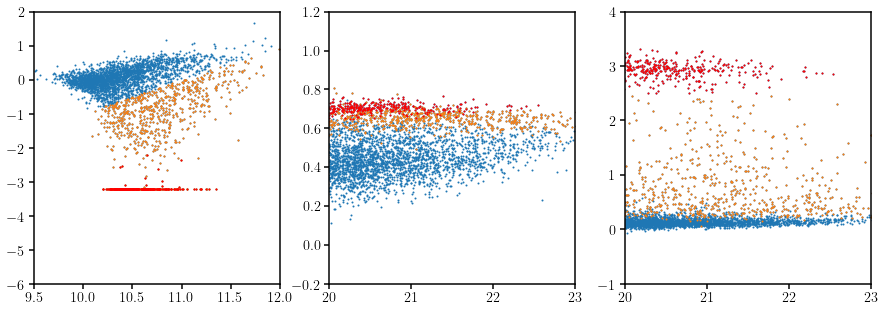

In [15]:
quiescent = (eagle['logsfr.inst'] - eagle['logmstar'] < -11)
uv_red = (x_eagle[2] > 2.5)

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(131)
sub.scatter(eagle['logmstar'][x_eagle[0] > 20], eagle['logsfr.inst'][x_eagle[0] > 20],s=1)
sub.scatter(eagle['logmstar'][(x_eagle[0] > 20) & quiescent], 
            eagle['logsfr.inst'][(x_eagle[0] > 20) & quiescent],s=1)
sub.scatter(eagle['logmstar'][(x_eagle[0] > 20) & quiescent & uv_red], 
            eagle['logsfr.inst'][(x_eagle[0] > 20) & quiescent & uv_red], c='r', s=1)
sub.set_xlim(9.5, 12)
sub.set_ylim(-6, 2)

sub = fig.add_subplot(132)
sub.scatter(x_eagle[0], x_eagle[1], s=1)
sub.scatter(x_eagle[0][quiescent & ~uv_red], x_eagle[1][quiescent & ~uv_red], c='C1', s=1)
sub.scatter(x_eagle[0][quiescent & uv_red], x_eagle[1][quiescent & uv_red], c='r', s=1)
sub.set_xlim(20, 23)
sub.set_ylim(-0.2, 1.2)

sub = fig.add_subplot(133)
sub.scatter(x_eagle[0], x_eagle[2], s=1)
sub.scatter(x_eagle[0][quiescent & ~uv_red], x_eagle[2][quiescent & ~uv_red], c='C1', s=1)
sub.scatter(x_eagle[0][quiescent & uv_red], x_eagle[2][quiescent & uv_red], c='r', s=1)
sub.set_xlim(20, 23)
sub.set_ylim(-1, 4)

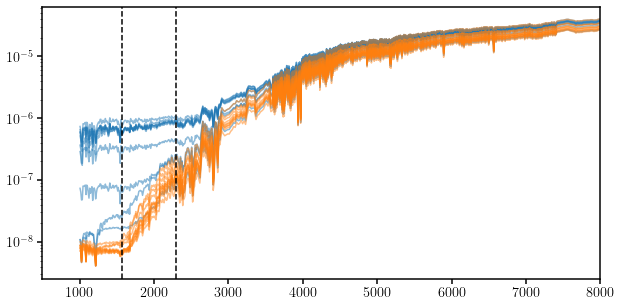

In [16]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for ii in np.random.choice(np.arange(len(eagle['logmstar']))[quiescent & ~uv_red & (eagle['logmstar'] > 10.5) & (eagle['logmstar'] < 10.6)], size=10, replace=False):
    sub.plot(eagle['wave'], eagle['sed_noneb'][ii,:].flatten(), c='C0', alpha=0.5)
    
for ii in np.random.choice(np.arange(len(eagle['logmstar']))[quiescent & uv_red & (eagle['logmstar'] > 10.5) & (eagle['logmstar'] < 10.6)], size=10, replace=False):
    sub.plot(eagle['wave'], eagle['sed_noneb'][ii,:].flatten(), c='C1', alpha=0.5)
sub.axvline(1565, color='k', linestyle='--')
sub.axvline(2300, color='k', linestyle='--')
sub.set_xlim(500, 8e3)
sub.set_yscale('log')

# TNG

(-1.0, 4.0)

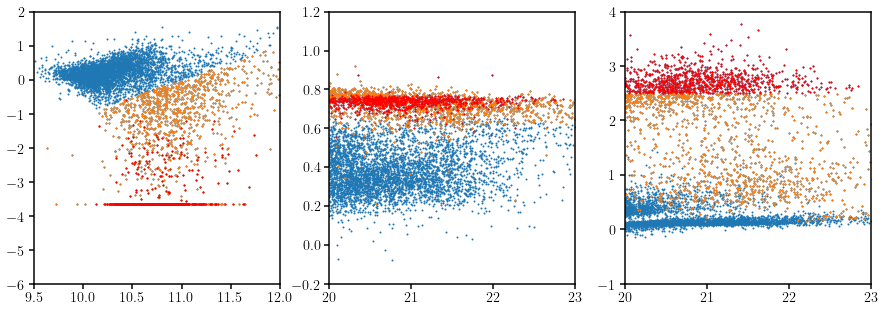

In [17]:
quiescent = (tng['logsfr.inst'] - tng['logmstar'] < -11)
uv_red = (x_tng[2] > 2.5)

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(131)
sub.scatter(tng['logmstar'][x_tng[0] > 20], tng['logsfr.inst'][x_tng[0] > 20],s=1)
sub.scatter(tng['logmstar'][(x_tng[0] > 20) & quiescent], 
            tng['logsfr.inst'][(x_tng[0] > 20) & quiescent],s=1)
sub.scatter(tng['logmstar'][(x_tng[0] > 20) & quiescent & uv_red], 
            tng['logsfr.inst'][(x_tng[0] > 20) & quiescent & uv_red], c='r', s=1)
sub.set_xlim(9.5, 12)
sub.set_ylim(-6, 2)

sub = fig.add_subplot(132)
sub.scatter(x_tng[0], x_tng[1], s=1)
sub.scatter(x_tng[0][quiescent & ~uv_red], x_tng[1][quiescent & ~uv_red], c='C1', s=1)
sub.scatter(x_tng[0][quiescent & uv_red], x_tng[1][quiescent & uv_red], c='r', s=1)
sub.set_xlim(20, 23)
sub.set_ylim(-0.2, 1.2)

sub = fig.add_subplot(133)
sub.scatter(x_tng[0], x_tng[2], s=1)
sub.scatter(x_tng[0][quiescent & ~uv_red], x_tng[2][quiescent & ~uv_red], c='C1', s=1)
sub.scatter(x_tng[0][quiescent & uv_red], x_tng[2][quiescent & uv_red], c='r', s=1)
sub.set_xlim(20, 23)
sub.set_ylim(-1, 4)

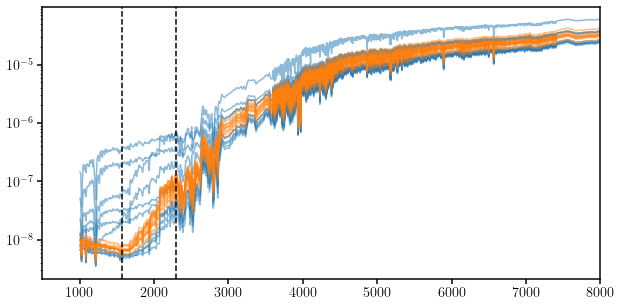

In [18]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for ii in np.random.choice(np.arange(len(tng['logmstar']))[quiescent & ~uv_red & (tng['logmstar'] > 10.5) & (tng['logmstar'] < 10.6)], size=10, replace=False):
    sub.plot(tng['wave'], tng['sed_noneb'][ii,:].flatten(), c='C0', alpha=0.5)
    
for ii in np.random.choice(np.arange(len(tng['logmstar']))[quiescent & uv_red & (tng['logmstar'] > 10.5) & (tng['logmstar'] < 10.6)], size=10, replace=False):
    sub.plot(tng['wave'], tng['sed_noneb'][ii,:].flatten(), c='C1', alpha=0.5)
sub.axvline(1565, color='k', linestyle='--')
sub.axvline(2300, color='k', linestyle='--')
sub.set_xlim(500, 8e3)
sub.set_yscale('log')